# Imports

In [52]:
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from IPython.display import Image

## Loading data

In [3]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

In [4]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Descrição dos Dados


In [7]:
df1 = df_raw.copy()

## 1.1 Rename Columns


In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

cols_new = []

for c in cols_old:
    cols_new.append(inflection.underscore(c))
    
df1.columns = cols_new

## 1.2 Data Dimension

In [9]:
print(f'Número de Linhas: {df1.shape[0]}')
print(f'Número de Colunas: {df1.shape[1]}')

Número de Linhas: 1017209
Número de Colunas: 18


## 1.3 Data Types

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [13]:
# competition_distance
# as distância que não existem vamos colocar 200000, que é um valor muito maior que a maior distância
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if np.isnan(x) else x)

# competition_open_since_month    
# vamos completar os Na's com o mês da coluna 'date'
df1['competition_open_since_month'] = df1[['date','competition_open_since_month']].apply(lambda x: x['date'].month
                                                                                        if np.isnan(x['competition_open_since_month'])
                                                                                        else x['competition_open_since_month'], axis=1)

# competition_open_since_year   
# vamos completar os Na's com o ano da coluna 'date'
df1['competition_open_since_year'] = df1[['date','competition_open_since_year']].apply(lambda x: x['date'].year
                                                                                        if np.isnan(x['competition_open_since_year'])
                                                                                        else x['competition_open_since_year'], axis=1)


# promo2_since_week      

df1['promo2_since_week'] = df1[['date','promo2_since_week']].apply(lambda x: x['date'].week
                                                                   if np.isnan(x['promo2_since_week'])
                                                                   else x['promo2_since_week'], axis=1)

# promo2_since_year   

df1['promo2_since_year'] = df1[['date','promo2_since_year']].apply(lambda x: x['date'].year
                                                                   if np.isnan(x['promo2_since_year'])
                                                                   else x['promo2_since_year'], axis=1)

# promo_interval  
df1['promo_interval'].fillna(0, inplace=True)

month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
df1['month_map'] = df1['date'].dt.month.map(month_map)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 
                                                                   else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                                   else 0, axis=1)


## 1.6 Change Types

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(include=['object'])

### 1.7.1 Num Attributes

In [16]:
# Central Tendency
# média
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
# mediana
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion Tendency
dt1 = pd.DataFrame(num_attributes.apply(np.std)).T
dt2 = pd.DataFrame(num_attributes.apply(min)).T
dt3 = pd.DataFrame(num_attributes.apply(max)).T
dt4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dt5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dt6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

df_statistic = pd.concat([dt2, dt3, dt4, ct1, ct2, dt1, dt5, dt6]).T.reset_index()

In [17]:
# Renomeando as colunas
df_statistic.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [18]:
df_statistic

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [126]:
# sns.displot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: len(x.unique()))

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

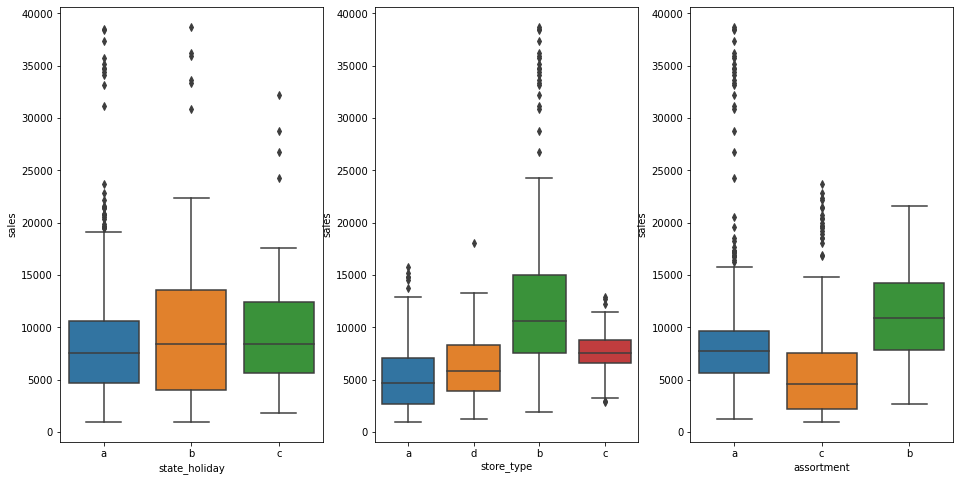

In [20]:
aux1 = df1[(df1['sales'] > 0) & (df1['state_holiday'] != '0')]

plt.subplot(1, 3, 1)
a1 = sns.boxplot(x='state_holiday', y='sales', data=aux1)
a1.figure.set_size_inches(16, 8)

plt.subplot(1, 3, 2)
a2 = sns.boxplot(x='store_type', y='sales', data=aux1)
a2.figure.set_size_inches(16, 8)

plt.subplot(1, 3, 3)
a3 = sns.boxplot(x='assortment', y='sales', data=aux1)
a3.figure.set_size_inches(16, 8)

In [29]:
df1.to_csv('datasets/data_train_store.csv', index=False)

# 2.0 Feature Engineering

In [129]:
df2 = pd.read_csv('datasets/data_train_store.csv', low_memory=False)

df2['date'] = pd.to_datetime(df2['date'])

## 2.1 Mapa Mental de Hipóteses

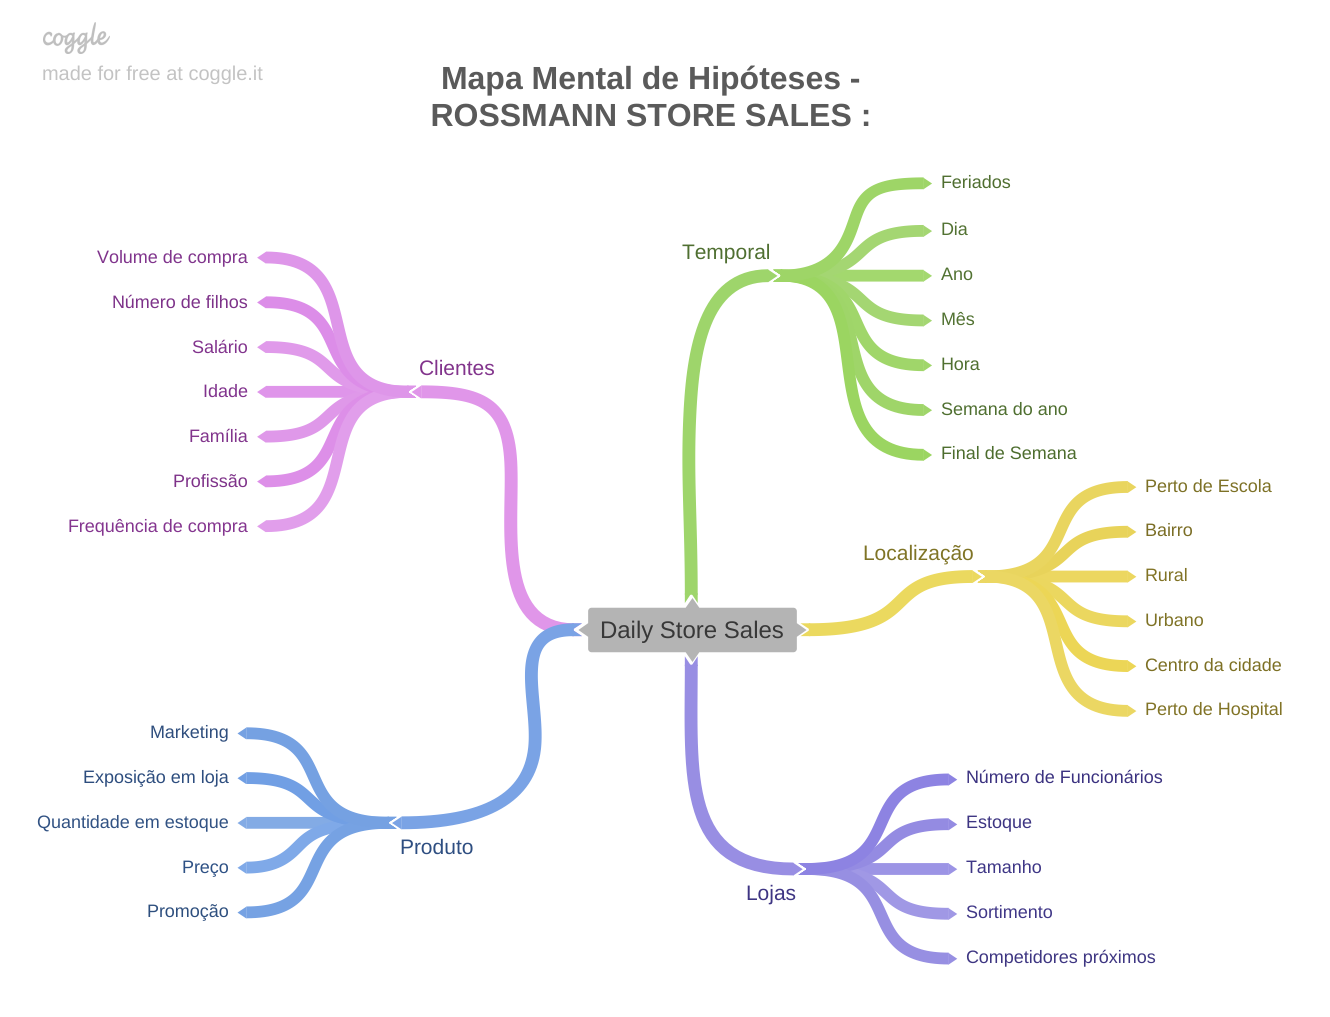

In [21]:
Image('img/mindmap_hypoteses.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses de Lojas

**H1.** Lojas com número maior de funcionários deveriam vender mais.

**H2.** Lojas com maior capacidade de estoque deveriam vender mais.

**H3.** Lojas com maior porte deveriam vender mais.

**H4.** Lojas com maior sortimentos deveriam vender mais.

**H5.** Lojas com competidores mais próximos deveriam vender menos.

**H6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipóteses dos Produtos 

**H1.** Lojas que investem mais em Marketing deveriam vender mais

**H2.** Lojas com maior exposição de produto deveriam vender mais.

**H3.** Lojas com produtos com preço menor deveriam vender mais.

**H5.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**H6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**H7.** Lojas com mais dias de promoção deveriam vender mais.

**H8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Temporais

**H1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**H2.** Lojas deveriam vender mais ao longo dos anos.

**H3.** Lojas deveriam vender mais no segundo semestre do ano.

**H4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**H5.** Lojas deveriam vender menos aos finais de semana.

**H6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4 Lista Final de Hipóteses 

Depois de pensar em várias hipóteses, vamos selecionar aquelas que podemos analisar com dados que já temos agora.

**H1.** Lojas com maior sortimentos deveriam vender mais.

**H2.** Lojas com competidores mais próximos deveriam vender menos.


**H3.** Lojas com competidores à mais tempo deveriam vendem mais.

**H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**H5.** Lojas com mais dias de promoção deveriam vender mais.

**H7.** Lojas com mais promoções consecutivas deveriam vender mais.

**H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**H9.** Lojas deveriam vender mais ao longo dos anos.

**H10.** Lojas deveriam vender mais no segundo semestre do ano.

**H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**H12.** Lojas deveriam vender menos aos finais de semana.

**H13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Feature Engineering

In [130]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['moonth'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
df2['week_of_year'] = df2['week_of_year'].astype('int64') 

# formato da data: Year-Week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                 month=x['competition_open_since_month'],
                                                                 day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).dt.days.astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) + '-1'
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).dt.days

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else
                                                      'extra ' if x == 'b' else
                                                      'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                            'easter' if x == 'b' else
                                                            'christmas' if  x == 'c' else
                                                            'regular_day')

# 3.0 XXXXXX